In [1]:
import pandas as pd
from warnings import warn
import re
import matplotlib.pyplot as plt
import numpy as np
import crcmod
from source import *
import os
import math

# https://docs.python.org/3/howto/logging.html
import logging
logger = logging.getLogger(__name__)
logging.basicConfig(filename='example.log', encoding='utf-8', level=logging.INFO)

In [2]:
"""This assumes a few things about the input data and then how that is processed"""
# Before capture ensure 10Mb/s instead of 100 or 1Gb/s, https://phoenixnap.com/kb/ethtool-command-change-speed-duplex-ethernet-card-linux

'This assumes a few things about the input data and then how that is processed'

<Axes: >

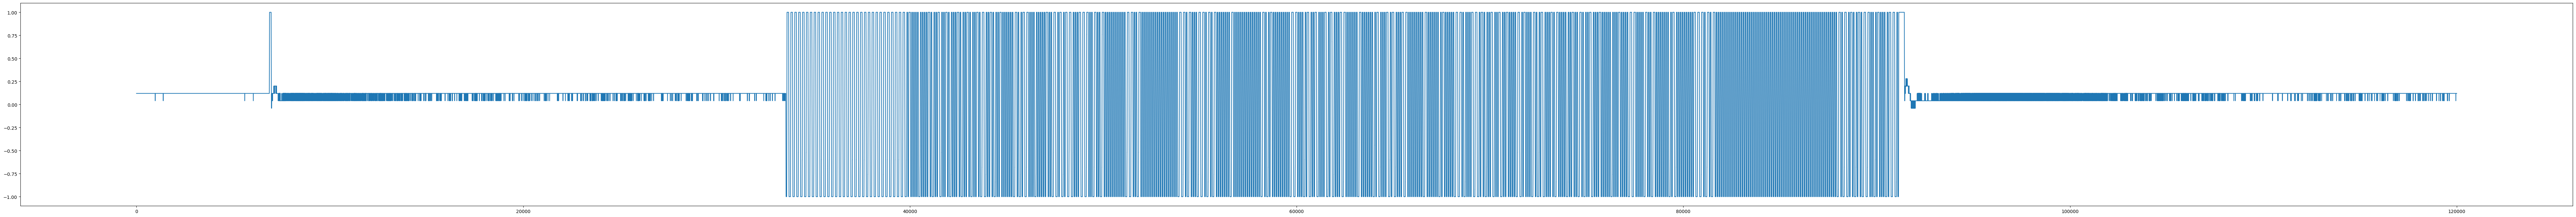

In [3]:
def get_capture(i='tcp_frame.csv', invert=True):
    
    """Get waveform capture data for NewFile{i}.csv, and optionally invert it.
    Data will be 'normalized' (clamped) from -1 to 1 V, for ease of visualization mostly.
    Compared with Ben Eater's result to realize that my wires were crossed and the preamble should 
    start with a dip-then-rise for the first bit logical 1 that the preamble starts off with.
    https://www.youtube.com/watch?v=xrVN9jKjIKQ  time 5:30 stillframe."""

    if type(i) == type('text'):
        path = f'ethernet_captures/{i}'
    else:
        path = f'ethernet_captures/NewFile{i}.csv'
        
    v_series = pd.read_csv(path, skiprows=1).iloc[:, 1]
    
    if invert:
        v_series = -v_series
    
    v_series = v_series.apply(clamp)
    return v_series

# Preview
v_series = get_capture()
v_series.plot(figsize=(100, 8))

In [4]:
# Get the bitstream df which has a Q value at each time there is a new bit on the wire, and then take all those and make it into a 
# python string for some fun with chunking and reversing to work with it.
bit_df = parse_manchester(v_series)
rawbits = ''.join(bit_df.Q.tolist())
print(rawbits)
len(rawbits)

0001010101010101010101010101010101010101010101010101010101010101100000111110011101110011110011100111001011100111000000010011010000111111000101101101011110101000100010000000000001010001000000000000000000001010010000101001001000000001000000000000000100110000000000101000011011101111011011110100000001000000011011110110111101000000000100000001100000010100111101011001110111011100000101100001001101111001000001110001001110111100000011110000010100000100010000000011011111111110101001001000000000000000000000000000000000000000000000000000000000000000010010110011001010001100001101011


577

In [5]:
# For plotting, we need to associate a bit-index (n) with each and every point on the waveform.
# We do a simple forward-fill such that all the space in between bit-changes is filled with the corresponding bit index.
# We start at -1 because there is no bit index associated with the very beginning of the waveform, before the preamble even began.
# The beginning 1 (or whatever it registers as...) of the preamble has bit index 0, and the destination mac address start bit
# will be calculated next based on finding the SFD.
df = ffill_Q_index(bit_df, v_series)
df.head(3)

,Volt,n,Q
0,0.12,-1,NaN
1,0.12,-1,NaN
2,0.12,-1,NaN


In [6]:
# GET BINARY STRING THAT IS STRICTLY THE ETHERNET PROTECTED FIELDS + CRC
# ALSO GET BINARY OCTET STRING ARRAY OF THE SAME, WITH BITS IN REVERSED ORDER FROM TRANSMISSION (SINCE EACH BYTE IS SENT LSB FIRST)

# calculate start of ethernet frame and various bit indices for convenience
dest_mac_start = find_end_of_preamble(rawbits)
dest_mac_stop = dest_mac_start + 48
source_mac_start = dest_mac_stop
source_mac_stop = source_mac_start + 48
ethertype_start = source_mac_stop
ethertype_stop = ethertype_start + 16

fcs_start = len(rawbits) - 4*8
fcs_stop = len(rawbits)

# Let us take the entire received bit-stream and turn it into BYTES, knowing that they are sent 
# highest-to-lowest byte at a time, each byte sent LSB first.

frame_bits = rawbits[dest_mac_start:]

# Chop off any extra bits that make it not a multiple of 8
L = len(rawbits[dest_mac_start:])
L = -(L%8)
if L != 0:
    frame_bits = frame_bits[:L]
    warn("Had to chop off bits from the end to make mult of 8. Did end of frame detection fail?")

frame_bytes = reverse_octets(chunk_octets(frame_bits))

# preview
frame_bytes[:5]

['11100000', '01110011', '11100111', '00111001', '10100111']

In [7]:
# CHECK ETHERNET CRC

# CRC PER 802.3 SECTION 3.2.9
#generator = 0x104C11DB7
# generator = G(x) = x32 + x26 + x23 + x22 + x16 + x12 + x11 + x10 + x8 + x7 + x5 + x4 + x2 + x + 1
generator = (1<<32) + (1<<26) + (1<<23) + (1<<22) + (1<<16) + (1<<12) + (1<<11) + (1<<10) + (1<<8) + (1<<7) + (1<<5) + (1<<4) + (1<<2) + (1<<1) + (1<<0)
crc32_func = crcmod.mkCrcFun(generator, xorOut=0xFFFFFFFF, rev=False, initCrc=0xFFFFFFFF)

def crc32(crc_frame_bits, func=crc32_func):
    # step a, complement first 32 bits of frame
    for i in range(32):
        if crc_frame_bits[i] == '1':
            crc_frame_bits[i] = '0'
        else:
            crc_frame_bits[i] = '1'
    
    # step b, take the n bits in the order the arrived in, from destination mac start to end of frame, as coefficients
    crc_frame_bits = crc_frame_bits[:-32] # just lop off the crc that came with it
    
    # step c, shift bits by 32 and fill with 0, then divide by the generator
    # if we use an existing crc32 implementation... that should already shift the value before dividing by the generator
    crc_frame_bin = int(''.join(crc_frame_bits), base=2) #### << 32
    
    # convert data to bytes for crc func
    num_bytes = math.ceil(len(crc_frame_bits) / 8) + 4
    bytes = crc_frame_bin.to_bytes(num_bytes, 'big')
    
    # DO CRC CALCULATION AND GET REMAINDER 
    r = crc32_func(bytes) 
    
    # step d/e, complement the remainder r, and this is your final crc
    return r # crc32 func has "xor out" set to FFFFFFFF and this will complement the output as required by 802.3

# NO REVERSAL OF BITS in each byte of the frame, 802.3 section 3.2.9 specifies 'first bit' is the x^(n-1) coefficient
# it cannot be then, that the bit order is reversed within the bytes.
received_crc = int(frame_bits[-32:], base=2)
calculated_crc= crc32(list(frame_bits))
assert calculated_crc == received_crc
print(calculated_crc == received_crc)
print(received_crc)

True
2523207787


In [9]:
# ETHERNET FRAME DECODE

# Some common EtherType codes.
ethertypes = pd.read_csv('ethertype.csv')
ethertypes.loc[ethertypes.Hex.str.contains('0806|0800|86DD', regex=True, case=False)]

# https://en.wikipedia.org/wiki/MAC_address#Bit-reversed_notation

# 40:16:7e:b4:f5:8a <- this pc ubuntu desktop 
# c8:d7:19:08:56:66 <- cisco router
# of course, I had only assumed before which packet I had captured, the ICMP request or the response...
# Since the first mac field is the DESTINATION, I got the response packet!!!!!!!!!!

d_mac = macify(frame_bytes[:6])
s_mac = macify(frame_bytes[6:12])

print(f"Destination MAC  {d_mac}")
print(f"Source MAC       {s_mac}")

ethertype_bytes = frame_bytes[12:14]
ethertype = [hexify(o) for o in ethertype_bytes]
ethertype_hex_code = '0x' + ''.join(ethertype).upper()

ethertype_lookup = ethertypes.loc[ethertypes.Hex == ethertype_hex_code]
print(ethertype_lookup)
ETHERNET_NEXT_PROTO = ethertype_lookup.iloc[0, 1]
ETHERNET_NEXT_PROTO

Destination MAC  e0:73:e7:39:a7:73
Source MAC       40:16:7e:b4:f5:8a
         Hex                           Ethertype
1762  0x0800  Internet Protocol version 4 (IPv4)


'Internet Protocol version 4 (IPv4)'

In [10]:
# IPV4 PACKET DECODE (if this was the contained protocol)
print(ETHERNET_NEXT_PROTO)
print("")

# To decode Byte 2 of IPV4
dscpcodes = pd.read_csv('dscp-registry-2.csv')
dscpcodes['Value (Binary)'] = dscpcodes['Value (Binary)'].astype(str)
dscpcodes.head()

# recognized protocols carried by IP, some common examples for preview
next_ip_protos = pd.read_csv('protocol-numbers-1.csv')
next_ip_protos.loc[next_ip_protos.Keyword.str.contains('^icmp|^tcp|^udp$', regex=True, case=False, na=False)]

# using 2x 6 byte mac addresses + 2 byte ethertype, then knowing that ipv4 should have a 5x 32bit word header
ethernet_payload = frame_bytes[14:-4] # DATA PAYLOAD OF ETHERNET - NO CRC AT END

pdu_header = ethernet_payload 
# without extra options!

version_IHL = pdu_header[0]
hex_version_IHL = hexify(version_IHL)
print(f"Version/IHL 0b{version_IHL} 0x{version_IHL}")
print(f"IP Version is {hex_version_IHL[0]}, Header Length = {hex_version_IHL[1]}")
print("")

DSCP = pdu_header[1]
dscp_dec = int(DSCP, base=2)
dscp_result = dscpcodes.loc[dscpcodes['Value (Decimal)'] == dscp_dec]
print(f"DSCP Result (IPv4 byte 2) -> 0d{dscp_dec} -> Name : {dscp_result.iloc[0,0]}")
print("")

ipv4_total_length = pdu_header[2:4]
ipv4_total_length = int(''.join(ipv4_total_length), base=2)
print(f"Total IPv4 packet length = {ipv4_total_length} bytes")
print("")

ttl = pdu_header[8]
print(f"TTL = {int(ttl, base=2)}")
print("")

proto_dec = int(pdu_header[9], base=2)
lookup_proto=next_ip_protos.loc[next_ip_protos.Decimal==str(proto_dec)]
IPV4_NEXT_PROTO = lookup_proto.iat[0, 1]
IPV4_NEXT_PROTO_NAME = lookup_proto.iat[0,0]
print(f"Protocol number: {hex(proto_dec)} -> {IPV4_NEXT_PROTO}")
print("")

def get_ip(word):
    ip = '.'.join([str(int(i, base=2)) for i in word])
    return ip

print(f"Source IP = {get_ip(pdu_header[12:16])}")
print(f"Destination IP = {get_ip(pdu_header[16:20])}")
print("")

if hex_version_IHL[1] == '5':
    print("End of header")
    ipv4_data = ethernet_payload[20:] # frame_bytes[ethernet_payload_start+20 : ethernet_payload_start+ipv4_total_length]
    ipv4_data_size = len(ipv4_data) # ipv4_total_length - 20
else:
    warn("IPv4 header has options... header longer than 20 bytes after all")

Internet Protocol version 4 (IPv4)

Version/IHL 0b01000101 0x01000101
IP Version is 4, Header Length = 5

DSCP Result (IPv4 byte 2) -> 0d0 -> Name : CS0

Total IPv4 packet length = 40 bytes

TTL = 64

Protocol number: 0x6 -> TCP

Source IP = 123.123.1.1
Destination IP = 123.123.1.4

End of header


In [12]:
# UDP PACKET DECODE (if this was contained in ipv4)

def to_int(octet_list):
    s = ''.join(octet_list)
    return int(s, base=2)

def decode_bytes(octet_list):
    ints = [int(o, base=2) for o in octet_list]
    bytes = bytearray(ints)
    return bytes.decode(encoding='utf8')

def print_udp_header(ipv4_data):
    src_port = to_int(ipv4_data[0:2])
    dest_port = to_int(ipv4_data[2:4])
    length = to_int(ipv4_data[4:6])
    checksum = to_int(ipv4_data[6:8])

    print(f"UDP Source port: {src_port}")
    print(f"UDP Destination port: {dest_port}")
    print(f"Length: {length}")
    print(f"Checksum: {checksum}")
    return length

def print_udp_body(ipv4_data, length):
    udp_body = ipv4_data[8:length]
    text = decode_bytes(udp_body)
    print(text)

if IPV4_NEXT_PROTO == 'UDP':
    print(IPV4_NEXT_PROTO_NAME, IPV4_NEXT_PROTO)
    print("")

    l = print_udp_header(ipv4_data)
    print_udp_body(ipv4_data, l)
else:
    print(f"Other protocol delievered, {IPV4_NEXT_PROTO}")

Other protocol delievered, TCP


In [13]:
# TCP PACKET DECODE (if this was contained in ipv4)

def print_tcp_header(ipv4_data):
    src_port = to_int(ipv4_data[0:2])
    dest_port = to_int(ipv4_data[2:4])
    seq_number = to_int(ipv4_data[4:8])
    ack_number = to_int(ipv4_data[8:12])
    data_offset = int(ipv4_data[12][:4], base=2)
    reserved = int(ipv4_data[12][4:], base=2)
    assert reserved == 0
    flags = ipv4_data[13]
    
    window_size = to_int(ipv4_data[14:16])
    checksum = to_int(ipv4_data[16:18])
    urg_ptr = to_int(ipv4_data[18:20])

    print(f"TCP Source port: {src_port}")
    print(f"TCP Destination port: {dest_port}")
    print(f"Seq #: {seq_number}")
    print(f"Ack #: {ack_number}")
    print(f"Data Offset: {data_offset}")
    print(f"Flags: {flags}")
    FLAGS = ['CWR', 'ECE', 'URG', 'ACK', 'PSH', 'RST', 'SYN', 'FIN']
    zip_flags = zip(flags, FLAGS)
    print(list(zip_flags))
    # for flag in zip_flags:
    #     if flag[0] == '1':
    #         print(flag[1], " SET")
    print(f"Window Size: {window_size}")
    print(f"Checksum: {checksum}")
    print(f"Urgent Pointer: {urg_ptr}")
    return data_offset

def print_tcp_body(ipv4_data, data_offset):
    tcp_body = ipv4_data[data_offset * 4:] # 4 bytes per word in the header
    print("\nTCP body...")
    print(tcp_body)
    text = decode_bytes(tcp_body)
    print(text)

if IPV4_NEXT_PROTO == 'TCP':
    print(IPV4_NEXT_PROTO_NAME, IPV4_NEXT_PROTO)
    print("")
    
    data_offset = print_tcp_header(ipv4_data)
    print_tcp_body(ipv4_data, data_offset)
else:
    print(f'different protocol delievered, {IPV4_NEXT_PROTO}')

6 TCP

TCP Source port: 3220
TCP Destination port: 55260
Seq #: 489972815
Ack #: 1893998200
Data Offset: 5
Flags: 00010000
[('0', 'CWR'), ('0', 'ECE'), ('0', 'URG'), ('1', 'ACK'), ('0', 'PSH'), ('0', 'RST'), ('0', 'SYN'), ('0', 'FIN')]
Window Size: 502
Checksum: 49042
Urgent Pointer: 0

TCP body...
['00000000', '00000000', '00000000', '00000000', '00000000', '00000000']
      


In [14]:
# ICMP PACKET DECODE (if this was contained in ipv4)
icmp_types = load_icmp_types()
icmp_codes = load_icmp_codes()
# This is a list of sub-codes per ICMP Type, all in one table.
# Most types do not make use of this, and their code 0 is just 'standard' for what the ICMP type is.
print(icmp_types.loc[icmp_types.Type.isin(['0', '3', '8'])])
print(icmp_codes.head(3))

def print_icmp(ipv4_data):
    # this should be ICMP !!!
    icmp_type = ipv4_data[0]
    icmp_code = ipv4_data[1]
    icmp_checksum = ipv4_data[2:4]
    icmp_content = ipv4_data[4:8]
    
    type_code = str(int(icmp_type, base=2))
    type_lookup = icmp_types.loc[icmp_types.Type == type_code]
    print(type_lookup.set_index('Type'))
    #print(f"ICMP Type Code {type_lookup.Type}, {type_lookup.Name}")
    print("")
    
    code_lookup = icmp_codes.loc[(icmp_codes.Type == type_code) & (icmp_codes.Codes == icmp_code)]
    code_dec = int(icmp_code, base=2)
    print(f"Code {code_dec}")
    if code_dec != 0:
        print(code_lookup)
    else:
        print("Code 0 means nothing special. If it's echo request, it's echo request...")
    print("")
    
    print(f"Checksum: {icmp_checksum}")
    print("")
    
    print(f"Body: {icmp_content}")

if IPV4_NEXT_PROTO == 'ICMP':
    print_icmp(ipv4_data)
else:
    print(f"Other protocol delievered, {IPV4_NEXT_PROTO}")

  Type                     Name Reference
0    0               Echo Reply  [RFC792]
3    3  Destination Unreachable  [RFC792]
8    8             Echo Request  [RFC792]
  Codes           Description Reference Type
0     0               Bad SPI       NaN    0
2     2  Decompression Failed       NaN    0
3     3     Decryption Failed       NaN    0
Other protocol delievered, TCP


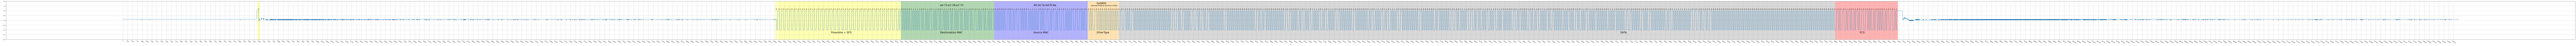

In [15]:
# GRAPH TOTAL RESULT knowing all the information that we decoded, overlaid on original ethernet mac frame waveform

# do new graph with shaded + labelled sections with respective values for ethernet
def compute_section_midpoint(df, start, end):
    local_midpoint = (start + end)//2
    p = int(df.loc[df.n == local_midpoint].reset_index().iloc[:, 0].mean())
    return p

# Plot the segments shaded over the raw waveform.
xticks = np.arange(0, len(df), 250)

fig, ax = plt.subplots()
plot = df.Volt.plot(
        figsize=(400, 6),  
        ax=ax, 
        xlabel='ns', 
        ylabel='V', 
        #color='red', 
        ylim=(-2, 2), 
        grid=True, 
        xticks=xticks
    )

xticks = np.arange(0, len(df), 10)
plt.xticks(rotation=-30)

# Shade regions for different sections of ethernet header, and annotate the sections
ax.fill_between(df.index, 4, -4, where=(df.n >= 0) & (df.n < dest_mac_start), facecolor='yellow', alpha=.3, offsets=(-15,0))
p = compute_section_midpoint(df, 1, dest_mac_start)
ax.annotate(text='Preamble + SFD', xy=(p-500, -1.35), fontsize=22)

ax.fill_between(df.index, 4, -4, where=(df.n >= dest_mac_start) & (df.n < source_mac_start), facecolor='green', alpha=.3, offsets=(-15,0))
p2 = compute_section_midpoint(df, dest_mac_start, dest_mac_stop)
ax.annotate(text='Destionation MAC', xy=(p2-500, -1.35), fontsize=22)
ax.annotate(text=d_mac, xy=(p2-500, 1.5), fontsize=22)

ax.fill_between(df.index, 4, -4, where=(df.n >= source_mac_start) & (df.n < ethertype_start), facecolor='blue', alpha=.3, offsets=(-15,0))
p3 = compute_section_midpoint(df, source_mac_start, source_mac_stop)
ax.annotate(text='Source MAC', xy=(p3-500, -1.35), fontsize=22)
ax.annotate(text=s_mac, xy=(p3-500, 1.5), fontsize=22)

ax.fill_between(df.index, 4, -4, where=(df.n >= ethertype_start) & (df.n < ethertype_stop), facecolor='orange', alpha=.3, offsets=(-15,0))
p4 = compute_section_midpoint(df, ethertype_start, ethertype_stop)
ax.annotate(text='EtherType', xy=(p4-450, -1.35), fontsize=22)
ax.annotate(text=ethertype_lookup.Hex.iloc[0], xy=(p4-450, 1.7), fontsize=22)
ax.annotate(text=ethertype_lookup.Ethertype.iloc[0], xy=(p4-750, 1.5), fontsize=14)

# red out 'data' section or make it gray, idk
# do I want to go into more depth like drill down to IP? not necesarilly. I want to use higher level 
# abstractions to look at that information, later, though. Just not on the bit stream... or do I? xD
ax.fill_between(df.index, 4, -4, where=(df.n >= ethertype_stop) & (df.n < fcs_start), facecolor='gray', alpha=.3, offsets=(-15,0))
p5 = compute_section_midpoint(df, ethertype_stop, 700)
ax.annotate(text='DATA', xy=(p5-450, -1.35), fontsize=22)

ax.fill_between(df.index, 4, -4, where=(df.n >= fcs_start) & (df.n < fcs_stop), facecolor='red', alpha=.3, offsets=(-15,0))
p6 = compute_section_midpoint(df, fcs_start, fcs_stop)
ax.annotate(text='FCS', xy=(p6-450, -1.35), fontsize=22)

for i, row in df.loc[~df.Q.isna()].iterrows():
    ax.annotate(text=row.Q, xy=(i - 40, 1.1), fontsize=15)  # 0.10

#fig.savefig('figure.png')